# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 25,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 5e-5, # L2 penalty.
    'num_workers': 8,     # Number of workers on data loader.
    'batch_size': 500,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'z_dim': 100,         # Dimension of z input vector.
    'num_samples': 4,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [0]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# Definindo o Gerador $G$

![Generator Architecture](https://www.dropbox.com/s/yf4d4sb1xcv8bma/GANs_Architecture_G.png?dl=1)

In [0]:
# Adversarial Generator.
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_channels=1, input_size=28):
    
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(128,
#                                64,
#                                kernel_size=(3, 3),
#                                stride=2,
#                                padding=1,
#                                output_padding=1),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
#             nn.ConvTranspose2d(64,
#                                self.output_channels,
#                                kernel_size=(3, 3),
#                                stride=2,
#                                padding=1,
#                                output_padding=1),
            nn.ConvTranspose2d(64, self.output_channels, 4, 2, 1),
            nn.Sigmoid(),
#             nn.Tanh(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        x = self.fc(x)
        
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        
        x = self.deconv(x)

        return x

# Instantiating G.
net_G = Generator(input_dim=args['z_dim']).to(args['device'])

# Printing architecture.
print(net_G)

# Definindo o Discriminador $D$

![Discriminator Architecture](https://www.dropbox.com/s/72s95njsuuag5m6/GANs_Architecture_D.png?dl=1)

In [0]:
# Adversarial Discriminator.
class Discriminator(nn.Module):
    
    def __init__(self, input_dim=1, output_channels=1, input_size=28):
        
        super(Discriminator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim,
                      64,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,
                      128,
                      kernel_size=(4, 4),
                      stride=2,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_channels),
#             nn.Sigmoid(),
        )
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
                
    def forward(self, x):
        
        x = self.conv(x)
        
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        
        x = self.fc(x)

        return x

# Instantiating D.
net_D = Discriminator().to(args['device'])

# Printing architecture.
print(net_D)

# Definindo o otimizadores

In [0]:
# TO DO: defining optimizer for G.
opt_G = optim.Adam(net_G.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# TO DO: defining optimizer for D.
opt_D = optim.Adam(net_D.parameters(),
                   lr=args['lr'],
                   weight_decay=args['weight_decay'])

# Definindo um Scheduler para os Learning Rates

In [0]:
# TO DO: defining lr scheduler.
scheduler_G = optim.lr_scheduler.StepLR(opt_G, args['epoch_num'] // 5, 0.5)
scheduler_D = optim.lr_scheduler.StepLR(opt_D, args['epoch_num'] // 5, 0.5)

# Definindo a loss composta

In [0]:
# TO DO: defining adversarial loss.
criterion = nn.MSELoss().to(args['device'])

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader,
          net_G, net_D,
          criterion,
          opt_G, opt_D,
          epoch,
          train_loss_G, train_loss_D):
    
    tic = time.time()
    
    # Predefining ones and zeros for batches.
    y_real = torch.ones(args['batch_size'], 1).to(args['device'])
    y_fake = torch.zeros(args['batch_size'], 1).to(args['device'])

    # Setting networks for training mode.
    net_D.train()
    net_G.train()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        
        # Obtaining images and labels for batch.
        x, labs = batch_data
        
        # TO DO: Creating random vector z.
        z = torch.rand((args['batch_size'], args['z_dim']))
        
        # TO DO: Casting to correct device (x and z).
        x = x.to(args['device'])
        z = z.to(args['device'])
        
        ###############
        # Updating D. #
        ###############
        
        # TO DO: Clearing the gradients of D optimizer.
        opt_D.zero_grad()

        # TO DO: Forwarding real data.
        D_real = net_D(x) # Through D.
        
        # TO DO: Computing loss for real data.
        D_real_loss = criterion(D_real, y_real)

        # TO DO: Forwarding fake data.
        G_out = net_G(z) # Through G.
        
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for fake data.
        D_fake_loss = criterion(D_fake, y_fake)

        # TO DO: Computing total loss for D.
        D_loss = D_real_loss + D_fake_loss
        
        # TO DO: Computing backpropagation for D.
        D_loss.backward()
        
        # TO DO: Taking step in D optimizer.
        opt_D.step()

        ###############
        # Updating G. #
        ###############
        
        # TO DO: Clearing the gradients of G optimizer.
        opt_G.zero_grad()

        # TO DO: Forwarding fake data.
        G_out = net_G(z) # Through G.
        
        D_fake = net_D(G_out) # Through D.
        
        # TO DO: Computing loss for G.
        G_loss = criterion(D_fake, y_real)
        
        # TO DO: Computing backpropagation for G.
        G_loss.backward()
        
        # TO DO: Taking step in G optimizer.
        opt_G.step()
        
        
        # Updating lists.
        train_loss_G.append(G_loss.data.item())
        train_loss_D.append(D_loss.data.item())

    toc = time.time()
    
    # Printing training epoch loss.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [training time %.2f]' % (
        epoch, (toc - tic)))
    print('-------------------------------------------------------------------')
    
    if epoch % args['print_freq'] == 0:
        
        # Plotting losses.
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        ax[0].plot(np.asarray(train_loss_G), 'r-', label='G loss')
        ax[0].legend()
        
        ax[1].plot(np.asarray(train_loss_D), 'b--', label='D loss')
        ax[1].legend()

        plt.show()
        
    return train_loss_G, train_loss_D

In [0]:
# Evaluating procedure.
def evaluate(net_G, criterion, epoch):
    
    # Setting networks for training mode.
    net_D.eval()
    net_G.eval()
    
    # Creating random vector z.
    z = torch.rand((args['num_samples'] * args['num_samples'], args['z_dim']))
    
    # Casting to correct device.
    z = z.to(args['device'])
    
    # Generating new samples.
    G_out = net_G(z)
    
    # Plotting.
    fig, ax = plt.subplots(args['num_samples'],
                           args['num_samples'],
                           figsize=(8, 8))
    
    for i in range(args['num_samples']):
        
        for j in range(args['num_samples']):
            
            sample = G_out[j * args['num_samples'] + i]
            
            ax[j, i].imshow(sample.detach().cpu().numpy().squeeze(),
                            cmap=plt.get_cmap('gray'))
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [training time 20.98]
-------------------------------------------------------------------


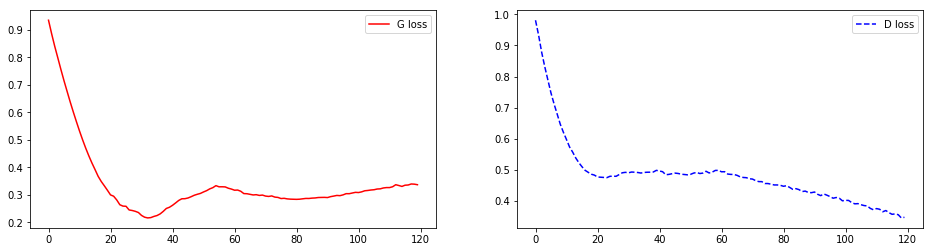

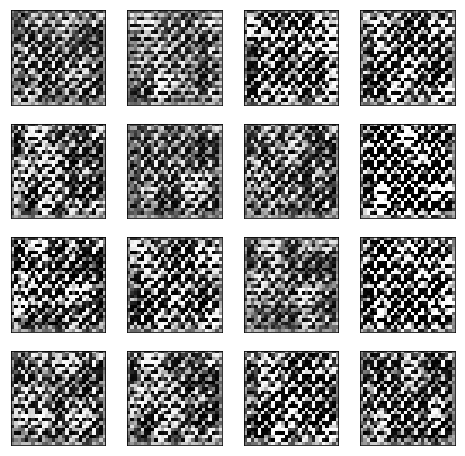

-------------------------------------------------------------------
[epoch 2], [training time 20.78]
-------------------------------------------------------------------


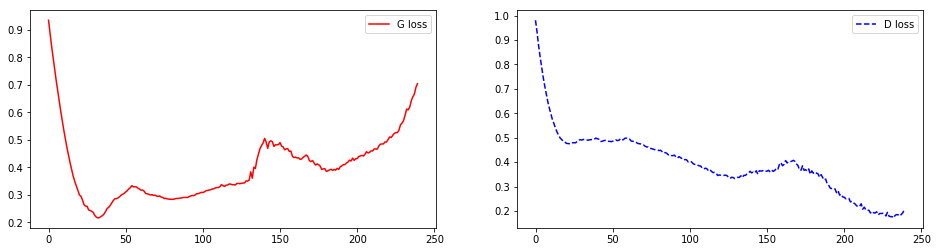

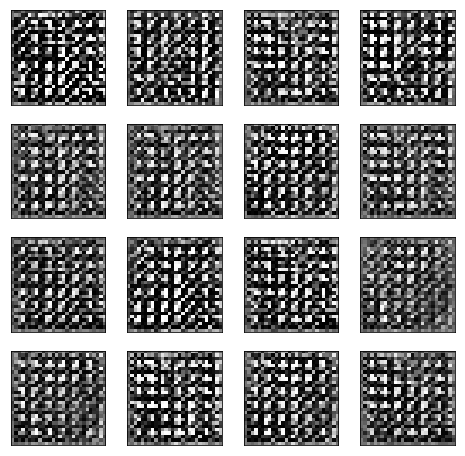

-------------------------------------------------------------------
[epoch 3], [training time 20.82]
-------------------------------------------------------------------


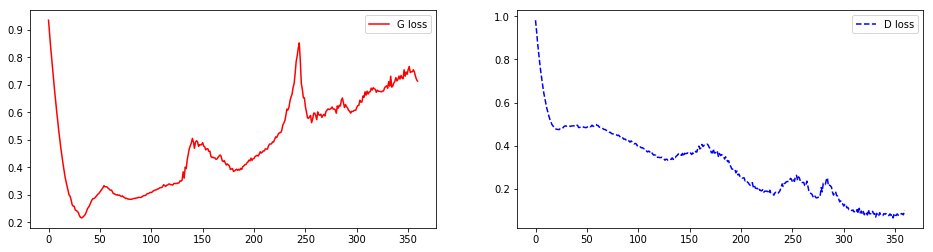

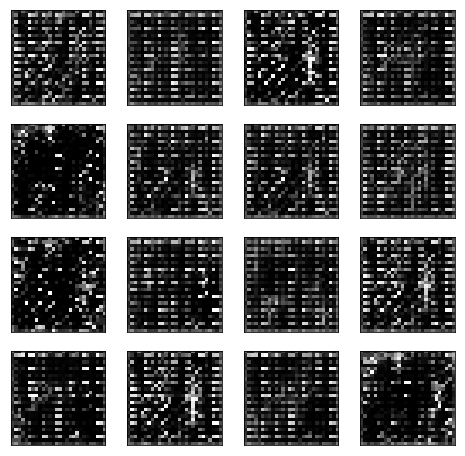

-------------------------------------------------------------------
[epoch 4], [training time 20.79]
-------------------------------------------------------------------


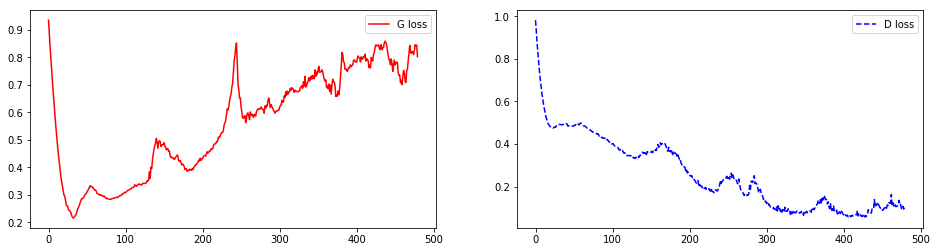

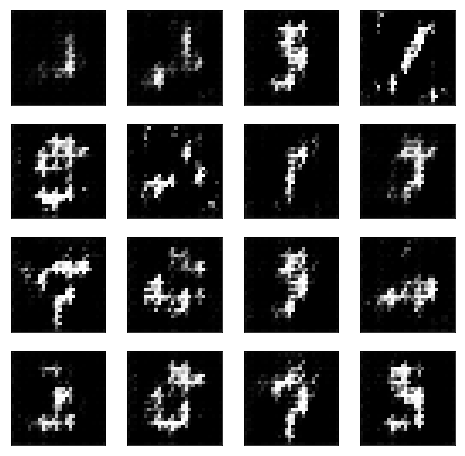

-------------------------------------------------------------------
[epoch 5], [training time 20.83]
-------------------------------------------------------------------


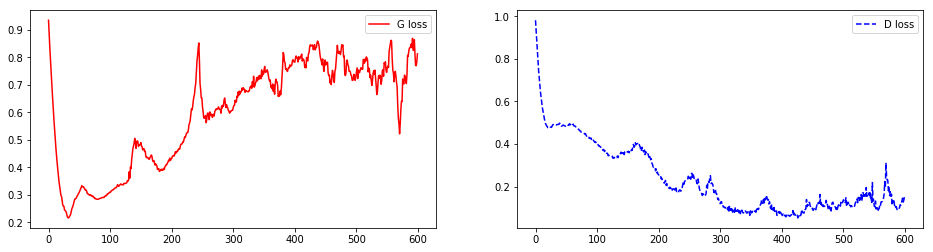

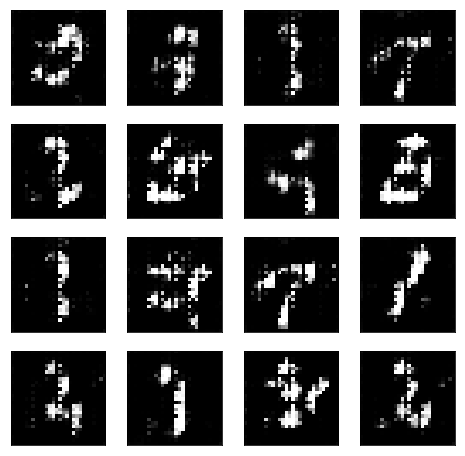

-------------------------------------------------------------------
[epoch 6], [training time 21.97]
-------------------------------------------------------------------


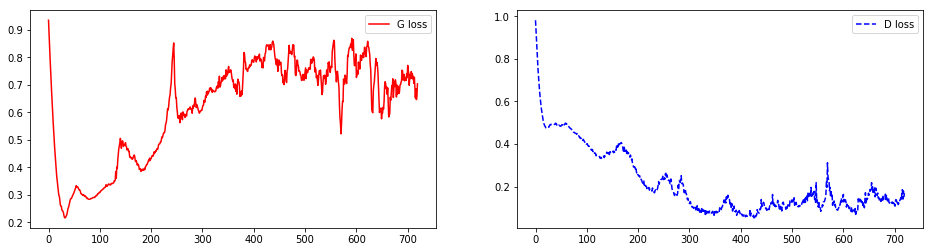

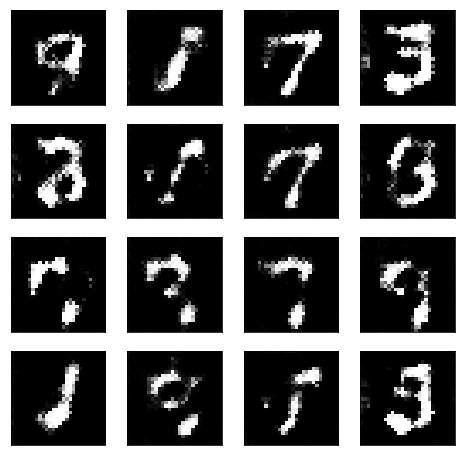

-------------------------------------------------------------------
[epoch 7], [training time 20.94]
-------------------------------------------------------------------


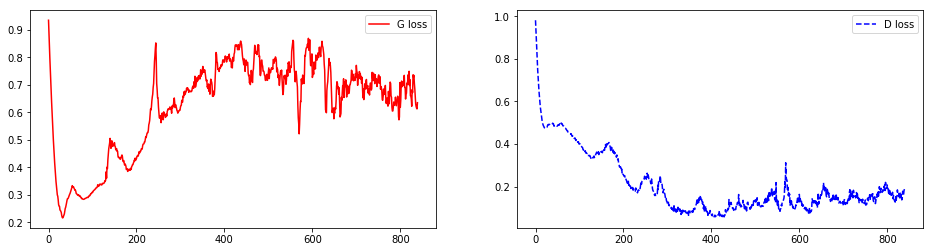

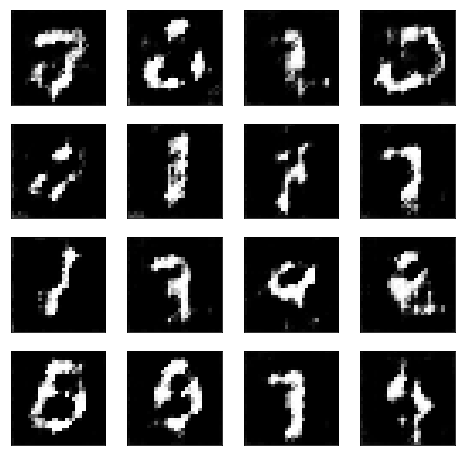

-------------------------------------------------------------------
[epoch 8], [training time 18.94]
-------------------------------------------------------------------


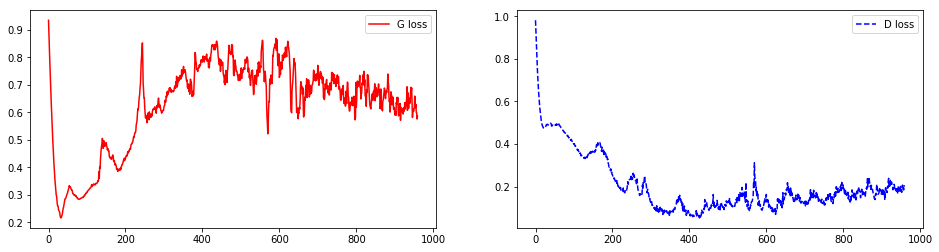

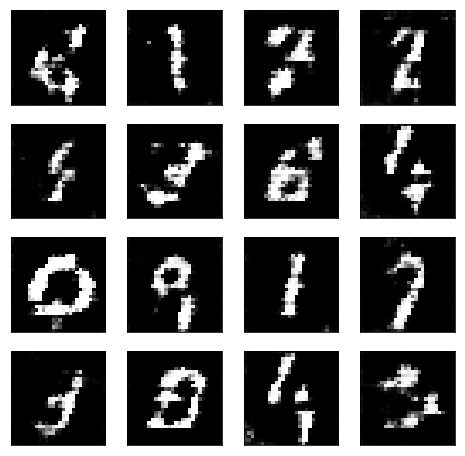

-------------------------------------------------------------------
[epoch 9], [training time 18.21]
-------------------------------------------------------------------


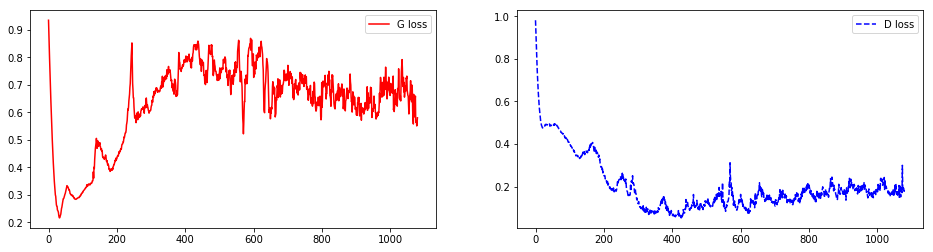

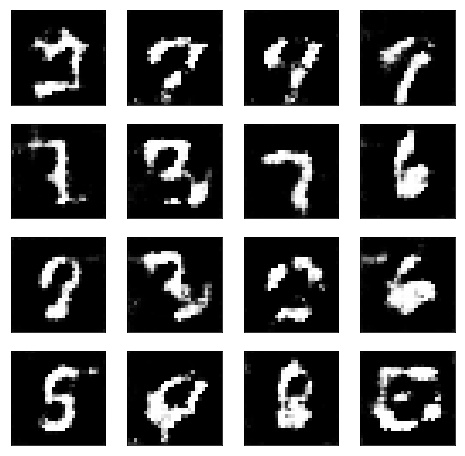

In [0]:
# Lists for losses.
train_loss_G = []
train_loss_D = []

# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train_loss_G, train_loss_D = train(train_loader,
                                       net_G, net_D,
                                       criterion,
                                       opt_G, opt_D,
                                       epoch,
                                       train_loss_G, train_loss_D)
    
    # Taking step on scheduler.
    scheduler_G.step()
    scheduler_D.step()

    if epoch % args['print_freq'] == 0:
        
        # Testing function for sample generation.
        evaluate(net_G, criterion, epoch)